In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.src.engine.data_adapter import train_validation_split
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image

import os
import os.path
import mediapipe as mp
import cv2

In [2]:
%matplotlib notebook

# Look At Your Data

In [3]:
df = pd.read_csv("D:\Documents\GitHub\CIR\emotion_classification\\non_smile_data\Aaron_Eckhart_0001.jpg.csv",
                 sep=';', usecols=[2,3,4])

df.head()

,x,y,z
0,0.478620,0.758943,-0.086969
1,0.498476,0.606925,-0.233838
2,0.492076,0.637054,-0.107097
3,0.476964,0.423226,-0.200634
4,0.504355,0.560891,-0.256577


In [6]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['x'], df['y'], df['z'])

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Z')

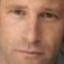

In [5]:
display(Image(filename="D:\Documents\GitHub\CIR\emotion_classification\\non_smile\Aaron_Eckhart_0001.jpg"))

In [6]:
df.loc[0]

x    0.478620
y    0.758943
z   -0.086969
Name: 0, dtype: float64

In [7]:
features = df.values
print(features)

[[ 0.4786202   0.7589426  -0.08696892]
 [ 0.49847609  0.60692495 -0.23383807]
 [ 0.4920764   0.63705415 -0.10709658]
 ...
 [ 0.60039616  0.2880252  -0.06108231]
 [ 0.85645998  0.24141848  0.02580323]
 [ 0.87857103  0.23326856  0.02423774]]


# Load Data from csv's

In [8]:
path = "D:\Documents\GitHub\CIR\emotion_classification"

AMOUNT_OF_FEATURES = 468
AMOUNT_OF_FILES = 0

df_non_smile = pd.DataFrame(dtype=float)
df_smile = pd.DataFrame(dtype=float)
df = pd.DataFrame(dtype=float)

classes = ["non_smile_data", "smile_data"]
for c in classes:
    for dirpath, dirnames, filenames in os.walk(f"D:\Documents\GitHub\CIR\emotion_classification\\{c}"):
         for filename in filenames:
            file_path = dirpath + "\\" + filename
            df_new = pd.read_csv(file_path, sep=";", usecols=[0,2,3,4])
            df = pd.concat([df, df_new])
            if c == "non_smile_data":
                df_non_smile = pd.concat([df_non_smile, df_new])
            elif c == "smile_data":
                df_smile = pd.concat([df_smile, df_new])
            AMOUNT_OF_FILES += 1
print(df)
print((AMOUNT_OF_FEATURES, AMOUNT_OF_FILES))

         Class         x         y         z
0    non_smile  0.478620  0.758943 -0.086969
1    non_smile  0.498476  0.606925 -0.233838
2    non_smile  0.492076  0.637054 -0.107097
3    non_smile  0.476964  0.423226 -0.200634
4    non_smile  0.504355  0.560891 -0.256577
..         ...       ...       ...       ...
463      smile  0.605286  0.257621 -0.051687
464      smile  0.588326  0.277888 -0.076196
465      smile  0.582146  0.297006 -0.104985
466      smile  0.804237  0.192636 -0.014957
467      smile  0.823666  0.177468 -0.015094

[438048 rows x 4 columns]
(468, 936)


In [9]:
print(df.values)

[['non_smile' 0.4786202013492584 0.7589426040649414 -0.0869689211249351]
 ['non_smile' 0.4984760880470276 0.6069249510765076 -0.2338380664587021]
 ['non_smile' 0.4920763969421386 0.6370541453361511 -0.1070965826511383]
 ...
 ['smile' 0.5821459889411926 0.2970063090324402 -0.1049851328134536]
 ['smile' 0.804236650466919 0.192635953426361 -0.0149569129571318]
 ['smile' 0.8236660957336426 0.1774682402610778 -0.0150936227291822]]


In [10]:
print(df.iloc[0])
print(df.iloc[467])

Class    non_smile
x          0.47862
y         0.758943
z        -0.086969
Name: 0, dtype: object
Class    non_smile
x         0.878571
y         0.233269
z         0.024238
Name: 467, dtype: object


In [11]:
X = df[['x', 'y', 'z']].values
Y = df['Class'].values

X = X.reshape(int(np.size(X) / (AMOUNT_OF_FEATURES * 3)), AMOUNT_OF_FEATURES, 3)
print(np.shape(X))

Y = Y[np.arange(0, np.size(Y), AMOUNT_OF_FEATURES)]
Y = np.where(Y == "non_smile", 0, 1)
print(np.shape(Y))

(936, 468, 3)
(936,)


# Construct model

In [12]:
model = models.Sequential()
model.add(layers.Conv1D(16, 3, activation='relu', input_shape=(AMOUNT_OF_FEATURES, 3)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 466, 16)           160       
                                                                 
 max_pooling1d (MaxPooling1  (None, 233, 16)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 231, 32)           1568      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 115, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 113, 64)           6208      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 56, 64)            0

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# Training loop
history = model.fit(X, Y, epochs=100, validation_split=0.2)

# Print history (optional)
# print(history.history)

Epoch 1/100
24/24 [==============================] - 2s 35ms/step - loss: 0.6604 - accuracy: 0.6297 - val_loss: 1.1545 - val_accuracy: 0.0000e+00
Epoch 2/100
24/24 [==============================] - 1s 23ms/step - loss: 0.6486 - accuracy: 0.6457 - val_loss: 0.8863 - val_accuracy: 0.0000e+00
Epoch 3/100
24/24 [==============================] - 1s 37ms/step - loss: 0.6295 - accuracy: 0.6497 - val_loss: 1.1790 - val_accuracy: 0.0000e+00
Epoch 4/100
24/24 [==============================] - 1s 40ms/step - loss: 0.6272 - accuracy: 0.6631 - val_loss: 1.0218 - val_accuracy: 0.0000e+00
Epoch 5/100
24/24 [==============================] - 1s 34ms/step - loss: 0.5935 - accuracy: 0.7005 - val_loss: 1.1365 - val_accuracy: 0.0957
Epoch 6/100
24/24 [==============================] - 1s 36ms/step - loss: 0.5527 - accuracy: 0.7393 - val_loss: 0.9700 - val_accuracy: 0.2713
Epoch 7/100
24/24 [==============================] - 1s 38ms/step - loss: 0.4491 - accuracy: 0.8182 - val_loss: 1.3406 - val_accurac

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
model2 = models.Sequential()
model2.add(layers.Conv1D(16, 3, activation='relu', input_shape=(AMOUNT_OF_FEATURES, 3)))
model2.add(layers.MaxPooling1D(2))
model2.add(layers.Conv1D(32, 3, activation='relu'))
model2.add(layers.MaxPooling1D(2))
model2.add(layers.Conv1D(64, 3, activation='relu'))
model2.add(layers.MaxPooling1D(2))
model2.add(layers.Conv1D(128, 3, activation='relu'))
model2.add(layers.MaxPooling1D(2))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(2))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 466, 16)           160       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 233, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 231, 32)           1568      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 115, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 113, 64)           6208      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 56, 64)           

In [20]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 466, 16)           160       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 233, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 231, 32)           1568      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 115, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 113, 64)           6208      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 56, 64)           

In [21]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
X_no_z = df[['x', 'y']].values

X_no_z = X_no_z.reshape(int(np.size(X_no_z) / (AMOUNT_OF_FEATURES * 2)), AMOUNT_OF_FEATURES, 2)
print(np.shape(X_no_z))

(936, 468, 2)


In [23]:
# Training loop
history2 = model2.fit(X, Y, epochs=100, validation_split=0.2)

# Print history (optional)
# print(history2.history)

Epoch 1/100
24/24 [==============================] - 2s 27ms/step - loss: 0.6530 - accuracy: 0.6324 - val_loss: 1.0998 - val_accuracy: 0.0000e+00
Epoch 2/100
24/24 [==============================] - 1s 23ms/step - loss: 0.6379 - accuracy: 0.6457 - val_loss: 0.8905 - val_accuracy: 0.0000e+00
Epoch 3/100
24/24 [==============================] - 0s 19ms/step - loss: 0.6105 - accuracy: 0.6457 - val_loss: 1.1259 - val_accuracy: 0.0000e+00
Epoch 4/100
24/24 [==============================] - 0s 18ms/step - loss: 0.5972 - accuracy: 0.6684 - val_loss: 0.9032 - val_accuracy: 0.1489
Epoch 5/100
24/24 [==============================] - 0s 18ms/step - loss: 0.5054 - accuracy: 0.7674 - val_loss: 0.8829 - val_accuracy: 0.4096
Epoch 6/100
24/24 [==============================] - 0s 19ms/step - loss: 0.3924 - accuracy: 0.8556 - val_loss: 0.5525 - val_accuracy: 0.7394
Epoch 7/100
24/24 [==============================] - 0s 19ms/step - loss: 0.3391 - accuracy: 0.8570 - val_loss: 0.3012 - val_accuracy: 0

In [24]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

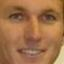

1/1 [==============================] - 0s 20ms/step
smile


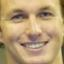

1/1 [==============================] - 0s 24ms/step
smile


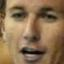

1/1 [==============================] - 0s 21ms/step
non_smile


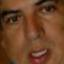

1/1 [==============================] - 0s 22ms/step
non_smile


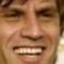

1/1 [==============================] - 0s 23ms/step
smile


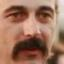

1/1 [==============================] - 0s 20ms/step
non_smile


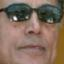

1/1 [==============================] - 0s 20ms/step
non_smile


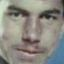

1/1 [==============================] - 0s 27ms/step
non_smile


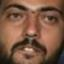

1/1 [==============================] - 0s 20ms/step
non_smile


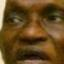

1/1 [==============================] - 0s 19ms/step
non_smile


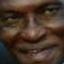

1/1 [==============================] - 0s 20ms/step
non_smile


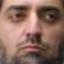

1/1 [==============================] - 0s 22ms/step
non_smile


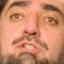

1/1 [==============================] - 0s 22ms/step
non_smile


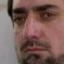

1/1 [==============================] - 0s 20ms/step
non_smile


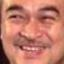

1/1 [==============================] - 0s 21ms/step
smile


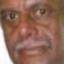

1/1 [==============================] - 0s 19ms/step
non_smile


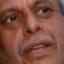

1/1 [==============================] - 0s 20ms/step
non_smile


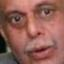

1/1 [==============================] - 0s 20ms/step
non_smile


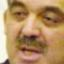

1/1 [==============================] - 0s 22ms/step
non_smile


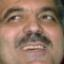

1/1 [==============================] - 0s 19ms/step
non_smile


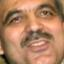

1/1 [==============================] - 0s 22ms/step
non_smile


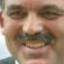

1/1 [==============================] - 0s 29ms/step
smile


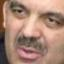

1/1 [==============================] - 0s 23ms/step
non_smile


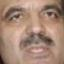

1/1 [==============================] - 0s 30ms/step
non_smile


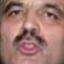

1/1 [==============================] - 0s 22ms/step
non_smile


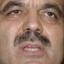

1/1 [==============================] - 0s 31ms/step
non_smile


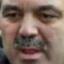

1/1 [==============================] - 0s 25ms/step
non_smile


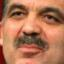

1/1 [==============================] - 0s 21ms/step
non_smile


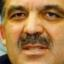

1/1 [==============================] - 0s 21ms/step
non_smile


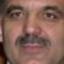

1/1 [==============================] - 0s 21ms/step
non_smile


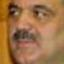

1/1 [==============================] - 0s 20ms/step
non_smile


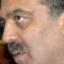

1/1 [==============================] - 0s 21ms/step
non_smile


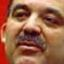

1/1 [==============================] - 0s 27ms/step
non_smile


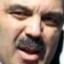

1/1 [==============================] - 0s 18ms/step
smile


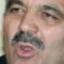

1/1 [==============================] - 0s 21ms/step
non_smile


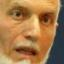

1/1 [==============================] - 0s 19ms/step
non_smile


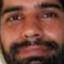

1/1 [==============================] - 0s 20ms/step
smile


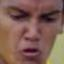

1/1 [==============================] - 0s 23ms/step
non_smile


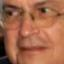

1/1 [==============================] - 0s 21ms/step
non_smile


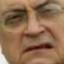

1/1 [==============================] - 0s 22ms/step
non_smile


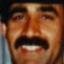

1/1 [==============================] - 0s 21ms/step
smile


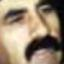

1/1 [==============================] - 0s 20ms/step
non_smile


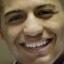

1/1 [==============================] - 0s 24ms/step
smile


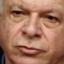

1/1 [==============================] - 0s 20ms/step
non_smile


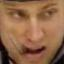

1/1 [==============================] - 0s 19ms/step
non_smile


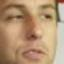

1/1 [==============================] - 0s 20ms/step
non_smile


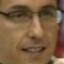

1/1 [==============================] - 0s 19ms/step
non_smile


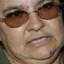

1/1 [==============================] - 0s 19ms/step
non_smile


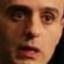

1/1 [==============================] - 0s 20ms/step
non_smile


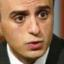

1/1 [==============================] - 0s 19ms/step
non_smile


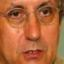

1/1 [==============================] - 0s 20ms/step
non_smile


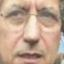

1/1 [==============================] - 0s 19ms/step
non_smile


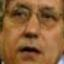

1/1 [==============================] - 0s 22ms/step
non_smile


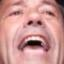

1/1 [==============================] - 0s 20ms/step
smile


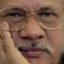

1/1 [==============================] - 0s 19ms/step
non_smile


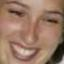

1/1 [==============================] - 0s 22ms/step
smile


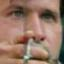

1/1 [==============================] - 0s 19ms/step
non_smile


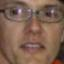

1/1 [==============================] - 0s 20ms/step
non_smile


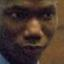

1/1 [==============================] - 0s 21ms/step
non_smile


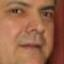

1/1 [==============================] - 0s 20ms/step
non_smile


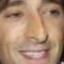

1/1 [==============================] - 0s 21ms/step
smile


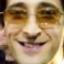

1/1 [==============================] - 0s 19ms/step
smile


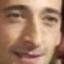

1/1 [==============================] - 0s 21ms/step
smile


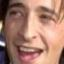

1/1 [==============================] - 0s 23ms/step
smile


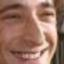

1/1 [==============================] - 0s 19ms/step
smile


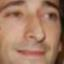

1/1 [==============================] - 0s 20ms/step
non_smile


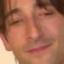

1/1 [==============================] - 0s 19ms/step
non_smile


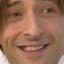

1/1 [==============================] - 0s 19ms/step
smile


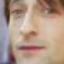

1/1 [==============================] - 0s 21ms/step
non_smile


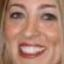

1/1 [==============================] - 0s 27ms/step
smile


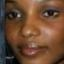

1/1 [==============================] - 0s 21ms/step
non_smile


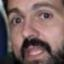

1/1 [==============================] - 0s 22ms/step
non_smile


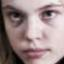

1/1 [==============================] - 0s 21ms/step
non_smile


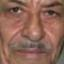

1/1 [==============================] - 0s 20ms/step
non_smile


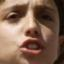

1/1 [==============================] - 0s 19ms/step
non_smile


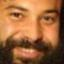

1/1 [==============================] - 0s 21ms/step
non_smile


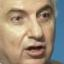

1/1 [==============================] - 0s 20ms/step
non_smile


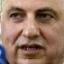

1/1 [==============================] - 0s 20ms/step
non_smile


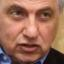

1/1 [==============================] - 0s 20ms/step
non_smile


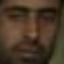

1/1 [==============================] - 0s 20ms/step
non_smile


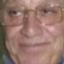

1/1 [==============================] - 0s 20ms/step
non_smile


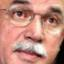

1/1 [==============================] - 0s 19ms/step
non_smile


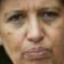

1/1 [==============================] - 0s 19ms/step
non_smile


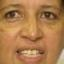

1/1 [==============================] - 0s 23ms/step
non_smile


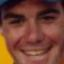

1/1 [==============================] - 0s 28ms/step
smile


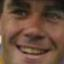

1/1 [==============================] - 0s 22ms/step
smile


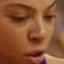

1/1 [==============================] - 0s 19ms/step
smile


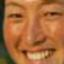

1/1 [==============================] - 0s 20ms/step
smile


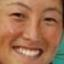

1/1 [==============================] - 0s 19ms/step
smile


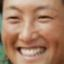

1/1 [==============================] - 0s 20ms/step
smile


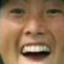

1/1 [==============================] - 0s 21ms/step
non_smile


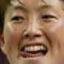

1/1 [==============================] - 0s 20ms/step
smile


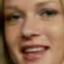

1/1 [==============================] - 0s 20ms/step
smile


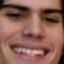

1/1 [==============================] - 0s 21ms/step
smile


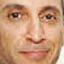

1/1 [==============================] - 0s 19ms/step
non_smile


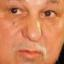

1/1 [==============================] - 0s 20ms/step
non_smile


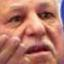

1/1 [==============================] - 0s 21ms/step
non_smile


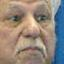

1/1 [==============================] - 0s 20ms/step
non_smile


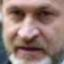

1/1 [==============================] - 0s 25ms/step
non_smile


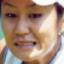

1/1 [==============================] - 0s 21ms/step
non_smile


In [52]:

for dirpath, dirnames, filenames in os.walk(f"D:\Documents\GitHub\CIR\emotion_classification\\test_data"):
    for filename in filenames[:100]:
        csv_path = dirpath + "/" + filename
        jpg_path = dirpath[:-5] + "/" + filename[:-4]
        display(Image(filename=jpg_path))
        df_pic = pd.read_csv(csv_path, sep=";", usecols=[0,2,3,4])
        X = df_pic[['x', 'y', 'z']].values
        X = X.reshape(int(np.size(X) / (AMOUNT_OF_FEATURES * 3)), AMOUNT_OF_FEATURES, 3)
        predictions = model.predict(X)
        c = np.argmax(predictions, axis=1)
        print(classes[c[0]][:-5])
        

In [53]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

def extract_face_landmarks(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
        results = face_mesh.process(image_rgb)
        if results.multi_face_landmarks:
          landmarks = results.multi_face_landmarks[0].landmark
        else:
          return None
    return landmarks

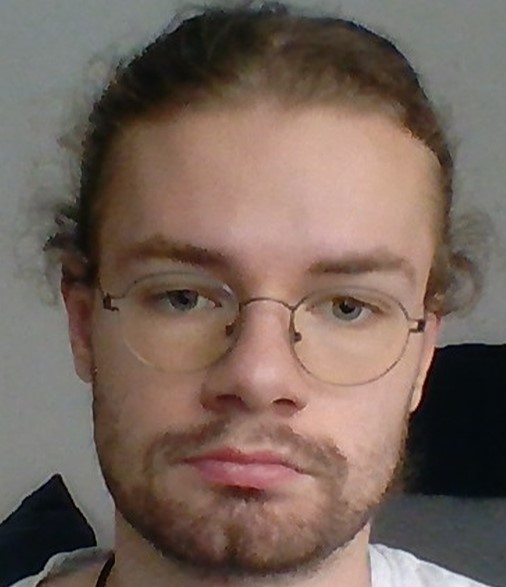

1/1 [==============================] - 0s 21ms/step
non_smile


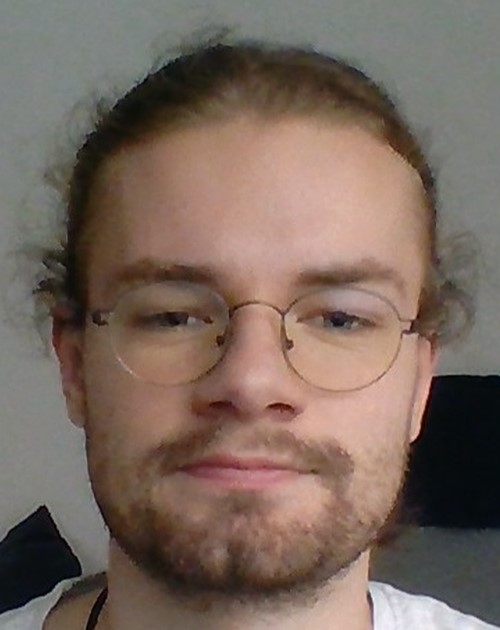

1/1 [==============================] - 0s 21ms/step
non_smile


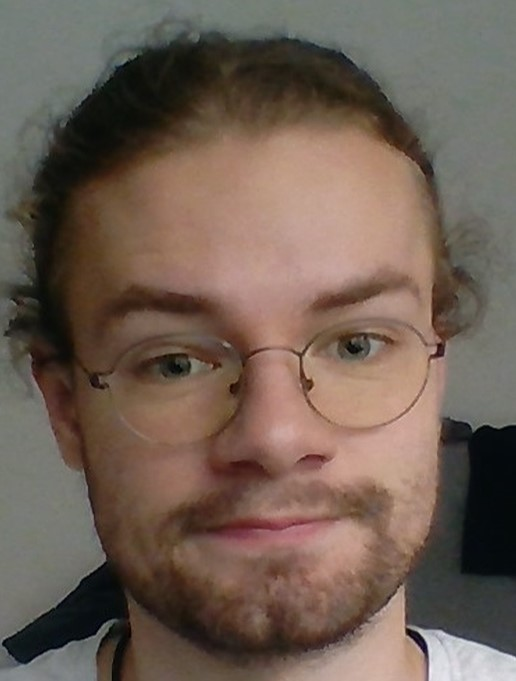

1/1 [==============================] - 0s 21ms/step
non_smile


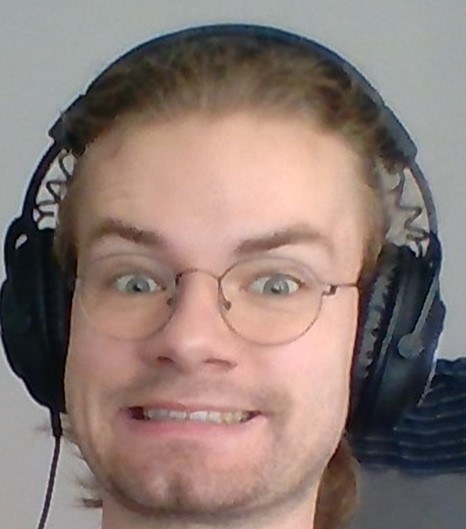

1/1 [==============================] - 0s 25ms/step
non_smile


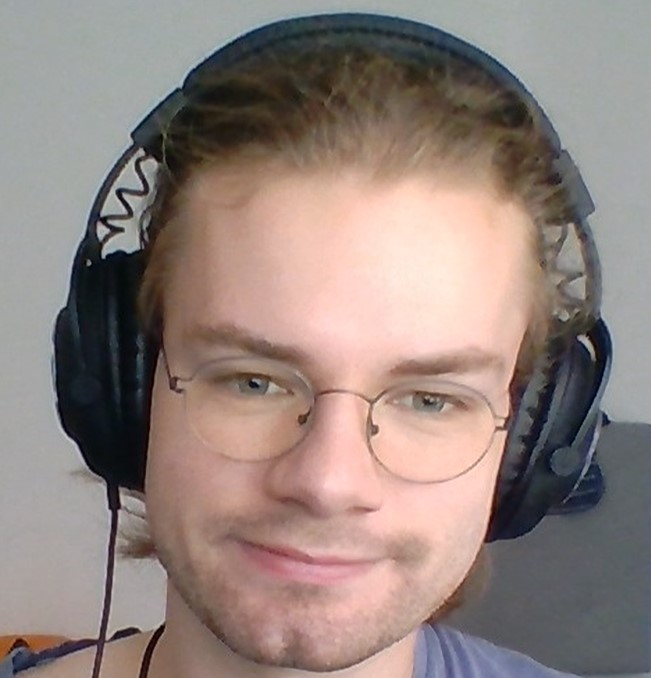

1/1 [==============================] - 0s 21ms/step
smile


In [73]:
self_test = [
    "D:\Documents\GitHub\CIR\emotion_classification\\neutral.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\\slightsmile.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\\smile.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\\opensmile.jpg",
     "D:\Documents\GitHub\CIR\emotion_classification\\natsmile.jpg",
     # "D:\Documents\GitHub\CIR\emotion_classification\\smile1.jpg",
     # "D:\Documents\GitHub\CIR\emotion_classification\\smile2.jpg",
     # "D:\Documents\GitHub\CIR\emotion_classification\\smile3.jpg",
     # "D:\Documents\GitHub\CIR\emotion_classification\\neutralgloria.jpg"
]

for test in self_test:
    x, y, z = [], [], []
    landmarks = extract_face_landmarks(test)
    display(Image(filename=test))
    for i, landmark in enumerate(landmarks):
        x.append(landmark.x)
        y.append(landmark.y)
        z.append(landmark.z)
    df = pd.DataFrame({"x": x, "y": y, "z": z})
    X = df[['x', 'y', 'z']].values
    X = X.reshape(int(np.size(X) / (AMOUNT_OF_FEATURES * 3)), AMOUNT_OF_FEATURES, 3)
    predictions = model.predict(X)
    c = np.argmax(predictions, axis=1)
    print(classes[c[0]][:-5])
        